# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Анализ вакансий.

Второй курс &mdash; самое время задуматься о будущей профессии и проанализировать существующие предложения. Дело тут даже не в том, чтобы найти интересную стажировку. В первую очередь сейчас стоит подумать о том, в какую сторону развиваться дальше. Например, если вы хотите работать в какой-либо конкретной профессии, то наверняка стоит развивать какие-то определенные навыки, и даже выбрать подходящую кафедру. Анализ существующих вакансий поможет определить, какие навыки вам нужны.

### <font color="blue"><i>Легкая часть</i></font>


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

import requests
from time import sleep
import json

### Задача 1.

Исследуем профессию Data Scientist. Найдите как можно больше вакансий по этой профессии в Москве. Учтите, что имеет смысл искать также по другим ключевым словам, например `аналитик данных`.

Сделаем тестовый запрос, чтобы понять основные параметры, по которым будем обрабатывать страницы:

In [6]:
URL = 'https://api.hh.ru/vacancies'
ds_params = dict(text="\"Data Scientist\" OR"
                      "\"Data Analysis\" OR"
                      "\"Data Analyst\" OR"
                      "\"Data Science\" OR"
                      "\"ML\" OR"
                      "\"Data Engineer\" OR"
                      "\"Big Data\" OR"
                      "\"Machine learning\" OR"
                      "\"Наука о данных\" OR"
                      "\"Анализ Данных\" OR"
                      "\"Инженер Данных\" OR"
                      "\"Kaggle\" OR"
                      "\"Аналитик Данных\" OR"
                      "\"Машинное обучение\"", area=1, page={}, per_page=100)
ds_req = requests.get(URL, ds_params)
ds_data = json.loads(ds_req.content.decode())

Согласно документации по API пользователю не может быть выдано более $2000$ вакансий. Таким образом, для дальнейшего анализа нам остаётся в лучшем случае имеено такое число.

Далее пройдёмся по всем страницам и соберём полный список вакансий:

In [7]:
ds_pages = []
for n in range(0, ds_data['pages']):
    ds_params['page'] = n
    req = requests.get(URL, ds_params)
    data = json.loads(req.content.decode())
    ds_pages.append(pd.json_normalize(data['items']))
    sleep(0.5)

Соберём таблицы вместе и выведем, чтобы представлять, как выглядят сырые данные:

In [8]:
ds_pages_df = pd.concat(ds_pages)
ds_pages_df.head()

,id,premium,name,department,has_test,response_letter_required,salary,response_url,sort_point_distance,published_at,...,address.metro,salary.from,salary.to,salary.currency,salary.gross,department.id,department.name,employer.logo_urls,insider_interview.id,insider_interview.url
0,52324250,False,Middle Data Scientist (Big Data),NaN,False,False,NaN,None,None,2022-03-17T14:31:11+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51703352,False,Аналитик данных (Data science),NaN,False,False,NaN,None,None,2022-03-17T12:39:28+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52234562,False,Data Engineer / Big data (Удаленно),NaN,False,False,NaN,None,None,2022-03-17T15:02:03+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52480091,False,Data analyst / Аналитик данных,NaN,False,False,NaN,None,None,2022-03-17T13:45:04+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53816693,False,Data Scientist,NaN,False,False,NaN,None,None,2022-03-17T18:46:11+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В полученную выборку некоторые вакансии могли попасть несколько раз. Удалите дубликаты.

Воспользуемся тем, что у одинаковых объявлений одинаковые id:

In [5]:
ds_pages_df.reset_index(inplace=True)
ds_pages_df.drop_duplicates(subset=['id'], inplace=True)
ds_pages_df.drop('index', axis=1, inplace=True)

Загрузите подробное описание каждой вакансии и создайте удобную таблицу данных.

In [10]:
ds_vacancies_info= []
ds_key_skills = []
ds_coord_lat = []
ds_coord_lng = []
ds_exp = []
ds_employer_name = []

for s in range(0, ds_pages_df.shape[0]):
    vacancy = ds_pages_df['id'].iloc[s]
    vacancy_url = f'https://api.hh.ru/vacancies/{vacancy}'
    req = requests.get(vacancy_url)
    vacancy_info = json.loads(req.content.decode())

    # на случай, если сервер перестанет отдавать ответы
    if 'errors' in vacancy_info:
        print("уходи, дудосер ٩(ఠ益ఠ)۶")
        break

    ds_vacancies_info.append(vacancy_info['description'])
    ds_key_skills.append([skill['name'] for skill in vacancy_info['key_skills']])

    # обрабатываем айди-имя работодателя
    if vacancy_info['employer'] is not None \
                and 'name' in vacancy_info['employer']:
        emp_name = vacancy_info['employer']['name']
        ds_employer_name.append(emp_name)
    else:
        ds_employer_name.append(None)

    # обрабатываем опыт работы
    if vacancy_info['experience'] is not None \
            and 'id' in vacancy_info['experience']:
        ds_exp.append(vacancy_info['experience']['id'])
    else:
        ds_exp.append(None)

    # обрабатываем координату работы
    if vacancy_info['address'] is not None \
        and 'lat' in vacancy_info['address'] \
            and 'lng' in vacancy_info['address'] :
        ds_coord_lat.append(vacancy_info['address']['lat'])
        ds_coord_lng.append(vacancy_info['address']['lng'])

    sleep(0.5)

Оставим важные для анализа поля. Для меня как для человека, который недавно искал работу, важна зарплата и описание вакансии вкупе с ключевыми навыками. Оставлю так же имя работодателя и требуемый опыт работы.

In [11]:
target_fields = ['id', 'name', 'salary.from', 'salary.to', 'salary.currency', 'salary.gross']
# TODO добавить адрес и работодателя потом
target_ds = ds_pages_df.loc[:, target_fields]
# добавляем необходимые для анализа поля
target_ds['vacancy_info'] = ds_vacancies_info
target_ds['key_skills'] = ds_key_skills
target_ds['experience'] = ds_exp
target_ds['employer_name'] = ds_employer_name

**Полученную таблицу необходимо сохранить в формате xlsx и отправить боту вместе с решением.**

In [111]:
target_ds.to_excel('ds_vacancy_info.xlsx')

**Вопрос 1.** Сколько сейчас доступно вакансий по вашему запросу?

In [13]:
data['found']

5324

Но, в связи с ограничениями API, к анализу доступно меньше, а именно, $2000$.

**Вопрос 2.** Какие навыки чаще всего встречаются в вакансиях по данной специальности?

Для этого найдите соответствующее поле в данных, проанализируйте его и составьте список навыков и количество упоминаний каждого. Визуализируйте полученную информацию по топ-15 навыков.

In [14]:
ds_skills_useability = {}
# идём по каждой вакансии, считаем упоминаемость навыков
for i in range(0, len(ds_key_skills)):
    for skill in ds_key_skills[i][:]:
        normalized_skill = skill.lower()
        if normalized_skill in ds_skills_useability:
            ds_skills_useability[normalized_skill] += 1
        else:
            ds_skills_useability[normalized_skill] = 1

Заметим, что навыки вроде 'Анализ данных' или подвиды SQL представляют для основной картины по навыкам несущественную роль. Объединим признаки по группам:

Text(0.5, 1.0, 'Анализ топ-15 навыков из резюме Data Science')

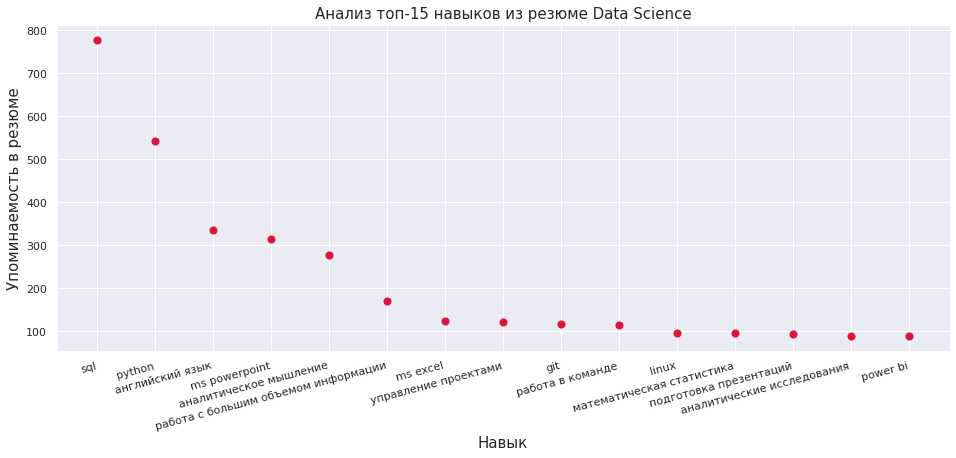

In [16]:
sk_tmp = ds_skills_useability.copy()
sk_tmp['sql'] += sk_tmp['ms sql'] + sk_tmp['postgresql']
sk_tmp.pop('ms sql')
sk_tmp.pop('postgresql')
sk_tmp.pop('анализ данных')
sk_tmp.pop('data analysis')
# формируем топ
sorted_useability = pd.DataFrame(sorted(sk_tmp.items(), key=lambda item: item[1], reverse=True),
                                 columns=['Навык', 'Упоминаемость'])

plt.figure(figsize=(16, 6))
sns.set(style='darkgrid')
plt.scatter(data=sorted_useability[0:15],
            x='Навык',
            y='Упоминаемость',
            marker='.',
            s=200,
            color='crimson')
plt.xlabel('Навык', fontsize=15)
plt.ylabel('Упоминаемость в резюме', fontsize=15)
plt.xticks(rotation=15, ha='right')
plt.title('Анализ топ-15 навыков из резюме Data Science', fontsize=15)

Таким образом, популярны инструменты работы с базами данных и инструменты визуализации.

**Вопрос 3.** Какую зарплату готовы платить работодатели? Соберите некоторым образом статистику и постройте гистограмму.

При работе с данными о заработной плате обратите внимание на валюту и <a target="_blank" href="https://yandex.ru/search/?text=gross%2Fnet&clid=1955455&win=446&lr=213&noreask=1">gross/net</a>.

Рассмотрим состояние данных о зарплате и постараемся привести их к более единому виду.

In [17]:
target_ds['salary.from'].count()

508

In [18]:
not_null_gross = target_ds['salary.gross'].count()
not_null_gross

588

In [19]:
target_ds['salary.to'].count()

390

Таким образом, заметим, что среди вакансий меньше чем в $30\%$ указана одна из двух границ вилок.
Оставим только необходимые для анализа поля:

In [229]:
salary_fields = ['salary.from', 'salary.to', 'salary.currency', 'salary.gross']
salary_info = target_ds.loc[:, salary_fields]
salary_info.dropna(inplace=True)

Рассмотрим число предложений с gross и net соответственно:

In [21]:
cnt_gross = target_ds['salary.gross'].sum()
print(cnt_gross, not_null_gross - cnt_gross)

192 396


Таким образом, работодатели чаще предпочитают указывать net в заработных платах.

В связи с тем, что европейский рынок рынок предлагает традиционно более высокую вилку, чем российский, расмотрим отдельно зарплаты в рублях и зарплаты в долларах и евро.
Посмотрим график по зарплате в рублях:

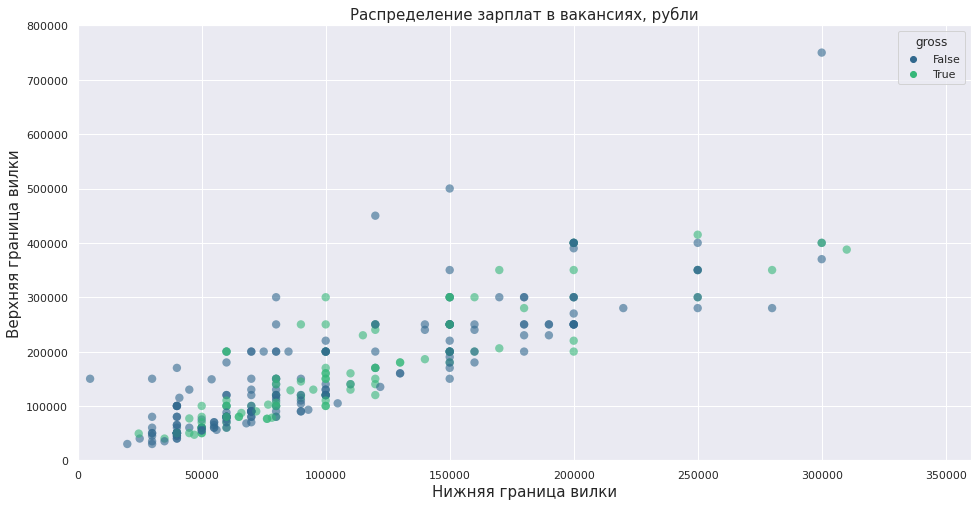

In [230]:
plt.figure(figsize=(16, 8))
sns.set(style='darkgrid')
rub_salary = salary_info[salary_info['salary.currency'] == 'RUR']
fig = sns.scatterplot(
    data=rub_salary,
    x='salary.from',
    y='salary.to',
    s=70,
    linewidth=0,
    hue='salary.gross',
    palette='viridis',
    alpha=0.6,
)

plt.xlim((0, 360000))
plt.ylim((0, 800000))
plt.ticklabel_format(style='plain')
plt.xlabel('Нижняя граница вилки', fontsize=15)
plt.ylabel('Верхняя граница вилки', fontsize=15)
plt.title('Распределение зарплат в вакансиях, рубли', fontsize=15)
plt.legend(title='gross')

Таким образом мы можем видеть, что нет явного превосходства одной группы зарплат над другой. Почти на каждое gross предложение есть похожее по вилке net. Тем временем, gross зарплаты не выбиваются в отдельную, более высокую по количеству денег категорию, таким образом, сэкономленные налоги не оказываются в кармане сотрудника.

Построим гистограмму распределения зарплат. В качестве значения для гистограммы возьмём среднее арифметическое между двумя границами:

Text(0.5, 1.0, 'Распределение размера зарплаты, рубли')

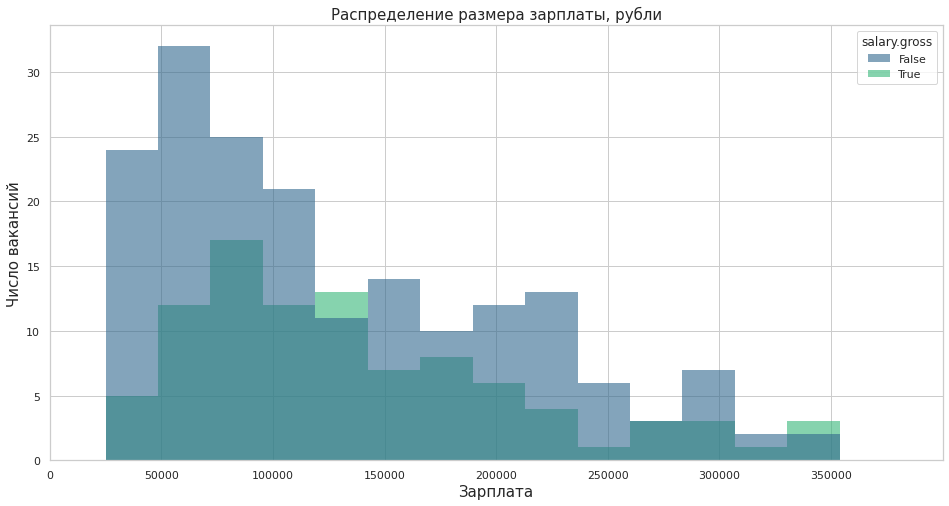

In [234]:
plt.figure(figsize=(16, 8))
sns.set(style='whitegrid')

fig = sns.histplot(
    data=rub_salary,
    x=0.5 * (rub_salary['salary.from'] + rub_salary['salary.to']),
    hue='salary.gross',
    linewidth=0,
    bins=50,
    palette='viridis',
    alpha=0.6,
)

xmin = 0
xmax = 400000
plt.xlim((xmin, xmax))
fig.set_xticks(np.arange(xmin, xmax, 50000))
plt.xlabel('Зарплата', fontsize=15)
plt.ylabel('Число вакансий', fontsize=15)
plt.title('Распределение размера зарплаты, рубли', fontsize=15)

Мы видим, что основная масса работодателей предпочитает нанимать сотрудников за $50-250$ тысяч рублей. Данная статистика соответствует информации по зарплатам, которую я смогла найти от реальных сотрудников на сайте `https://www.glassdoor.com/`. Заметим, что тенденция для зарплаты с налогами и без одинаковая, что ещё раз подтверждает вывод, сделанный по предыдущему графику.

Вычислим медианные границы:

In [235]:
rub_salary[rub_salary['salary.gross'] == False].median()

salary.from      80000.0
salary.to       130000.0
salary.gross         0.0
dtype: float64

In [236]:
rub_salary[rub_salary['salary.gross'] == True].median()

salary.from     100000.0
salary.to       142500.0
salary.gross         1.0
dtype: float64

Медианная зарплата:

In [26]:
np.median(0.5 * (rub_salary['salary.from'] + rub_salary['salary.to']))

110000.0

**Повторим те же действия для зарплат в иностранной валюте.**
Для удобства приведём все зарплаты к доллару:

In [ ]:
usd_eur_salary = salary_info.loc[salary_info['salary.currency'] != 'RUR']
# взято по официальному курсу
usd_div_eur = 0.91441
usd_eur_salary.loc[usd_eur_salary['salary.currency'] == 'EUR', ['salary.to', 'salary.from']] *= usd_div_eur
usd_eur_salary.loc[usd_eur_salary['salary.currency'] == 'EUR', 'salary.currency'] = 'USD'

Посмотрим, как работодатели, которые платят в иностранной валюте, предпочитают указывать: net или gross.

In [28]:
not_null_gross = usd_eur_salary['salary.gross'].count()
cnt_gross = usd_eur_salary['salary.gross'].sum()
print(cnt_gross, not_null_gross - cnt_gross)

11 18


Видим, что процент gross выше, чем в рублёвом случае. В традициях иностранных рынков указывать зарплату без налогов, что связано со сложной (прогрессивной) системой налогообложения и различными налоговыми законодательствах в географически близких странах европы.

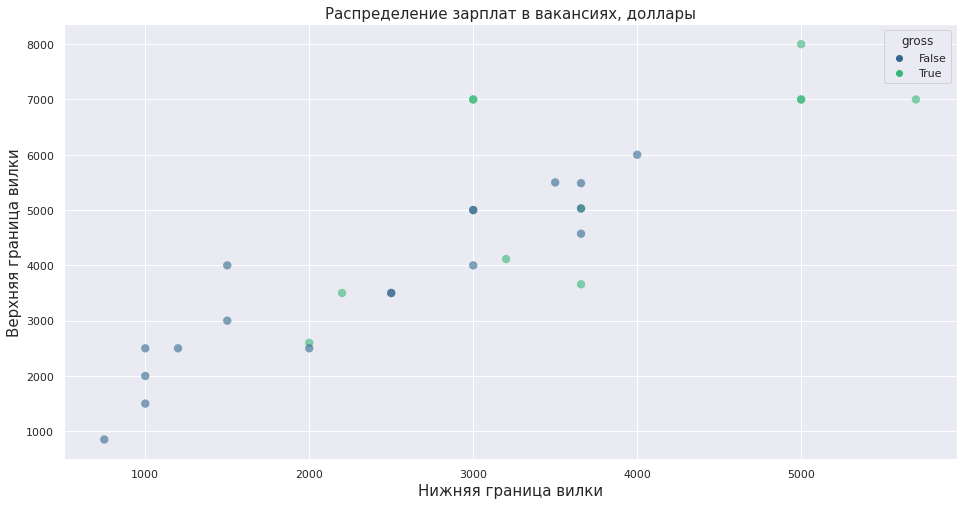

In [29]:
plt.figure(figsize=(16, 8))
sns.set(style='darkgrid')
fig = sns.scatterplot(
    data=usd_eur_salary,
    x='salary.from',
    y='salary.to',
    s=70,
    linewidth=0,
    hue='salary.gross',
    palette='viridis',
    alpha=0.6,
)

plt.ticklabel_format(style='plain')
plt.xlabel('Нижняя граница вилки', fontsize=15)
plt.ylabel('Верхняя граница вилки', fontsize=15)
plt.title('Распределение зарплат в вакансиях, доллары', fontsize=15)
plt.legend(title='gross')
plt.show()

Здесь мы наблюдаем, что вакансии gross находятся в среднем правее и ниже, чем группа net. Это означает, что в среднем по gross зарплата выше, но ширина вилки -- ниже, в отличие от рублёвых зарплат.

Поскольку мы имеем дело с маленькой выборкой по долларовым ЗП, гистограмма не является информативной.

In [30]:
usd_eur_salary[usd_eur_salary['salary.gross'] == False].median()

salary.from     2500.0
salary.to       3750.0
salary.gross       0.0
dtype: float64

In [31]:
usd_eur_salary[usd_eur_salary['salary.gross'] == True].median()

salary.from     3657.64
salary.to       7000.00
salary.gross       1.00
dtype: float64

Медианная зарплата:

In [32]:
np.median(0.5 * (usd_eur_salary['salary.from'] + usd_eur_salary['salary.to']))

3657.64

Таким образом, разброс зарплат сильнее, чем у рублёвых. Но строгие выводы делать сложно, так как в выборке представлено небольшое число USD вакансий.
По текущему курсу медианная зарплата $3.5 - 4.0$ раза выше, чем рублёвая.

**Вывод:**
1. Таким образом, существенная часть работодателей хочет нанимать к себе людей, которые знают SQL, Python, английский язык. Важно умение работать в команде, иметь сильные аналитические навыки. Так же необходимо владеть системами контроля версий, иногда $-$ обладать управленческими навыками и уметь презентовать свои исследования.
2. Зарплата рублёвого аналитика лежит в диапазоне $50-200k$ рублей, медианная оплата $100-115k$ в зависимости от различных скачиваний данных. Медианная зарплата в долларах составляет около $3800$$.
  Такой разброс обеспечен тем, что при анализе зарплат не были учитаны факторы занятости, количество обязанностей на месте работы, а так же уровень аналитика, на который ищут сотрудника. Все эти пункты требовали бы более детального анализа текстового описания вакансии. Так же в выборку попали вакансии как опытных специалистов, так и на стажёров, что так же вносит вклад на разброс зарплат и ширину интервала.
3. Зарплата без gross/net в рублях отличается меньше, чем в долларах, скорее всего, это связано с различной величиной налогов.
4. Это не было рассмотрено выше, но можно сказать, что поиск по ключевым словам довольно-таки точен, но есть ряд особенностей, которые можно потенциально улучшить: если слово "аналитик" встречается в названии вакансии, то это почти всегда то, что нас интересует. Если же ключевые слова встречаются в описании, прогноз менее точен, так как часто, например, ML компании ищут себе менеджера, и в вакансии рассказывают о себе как о компании. Этот пример демонстрирует самую популярную причину нахождения ложных вакансий из тех, что я наблюдала.

#### Задача 1.2

Проведите аналогичный анализ для наиболее привлекательной для вас профессии в любом регионе. Если это Data Scientist, то для анализа выберите другую.

Рассмотрю профессию менеджера в городе Санкт-Петербург. Повторим аналогичные действия. Рассматриваю одно ключевое слово, так как менеджера иначе как менеджером назвать сложно :)

In [172]:
URL = 'https://api.hh.ru/vacancies'
params = dict(text="\"Менеджер\"", area=1, page={}, per_page=100)
req = requests.get(URL, params)
m_data = json.loads(req.content.decode())

In [173]:
m_pages = []
for n in range(0, m_data['pages']):
    params['page'] = n
    req = requests.get(URL, params)
    m_data = json.loads(req.content.decode())
    m_pages.append(pd.json_normalize(m_data['items']))
    sleep(0.5)

In [178]:
m_pages_df = pd.concat(m_pages)

m_pages_df.reset_index(inplace=True)
m_pages_df.drop_duplicates(subset=['id'], inplace=True)
m_pages_df.drop('index', axis=1, inplace=True)

**Вопрос 1.** Сколько сейчас доступно вакансий по вашему запросу?

In [179]:
m_data['found']

37507

**Вопрос 2.** Какие навыки чаще всего встречаются в вакансиях по данной специальности?

Для этого найдите соответствующее поле в данных, проанализируйте его и составьте список навыков и количество упоминаний каждого. Визуализируйте полученную информацию по топ-15 навыков.

In [186]:
from tqdm.notebook import tqdm
bar = tqdm(range(0, m_pages_df.shape[0]))

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
m_vacancies_info= []
m_key_skills = []
m_exp = []
m_employer_name = []

In [206]:
for s in range(0, m_pages_df.shape[0]):
    vacancy = m_pages_df['id'].iloc[s]
    vacancy_url = f'https://api.hh.ru/vacancies/{vacancy}'
    req = requests.get(vacancy_url)
    vacancy_info = json.loads(req.content.decode())

    # на случай, если сервер перестанет отдавать ответы
    if 'errors' in vacancy_info:
        print("уходи, дудосер ٩(ఠ益ఠ)۶")
        break

    m_vacancies_info.append(vacancy_info['description'])
    m_key_skills.append([skill['name'] for skill in vacancy_info['key_skills']])

    # обрабатываем айди-имя работодателя
    if vacancy_info['employer'] is not None \
            and 'name' in vacancy_info['employer']:
        emp_name = vacancy_info['employer']['name']
        m_employer_name.append(emp_name)
    else:
        m_employer_name.append(None)

    # обрабатываем опыт работы
    if vacancy_info['experience'] is not None \
            and 'id' in vacancy_info['experience']:
        m_exp.append(vacancy_info['experience']['id'])
    else:
        m_exp.append(None)

    bar.update()
    sleep(0.5)

In [207]:
target_fields = ['id', 'name', 'salary.from', 'salary.to', 'salary.currency', 'salary.gross']
target_m = m_pages_df.loc[:, target_fields]
target_m['vacancy_info'] = m_vacancies_info
target_m['key_skills'] = m_key_skills

Сохраняем в таблицу:

In [216]:
target_m.to_excel('manager_df.xlsx')

Рассмотрим навыки:

In [209]:
m_skills_useability = {}
# идём по каждой вакансии, считаем упоминаемость навыков
for i in range(0, len(m_key_skills)):
    for skill in m_key_skills[i][:]:
        normalized_skill = skill.lower()
        if normalized_skill in m_skills_useability:
            m_skills_useability[normalized_skill] += 1
        else:
            m_skills_useability[normalized_skill] = 1

Text(0.5, 1.0, 'Анализ топ-15 навыков из резюме менеджеров')

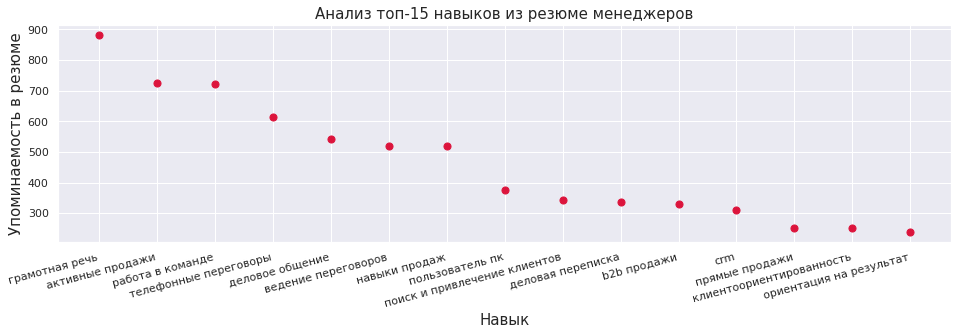

In [210]:
sk_tmp = m_skills_useability.copy()
dict_sorted = sorted(sk_tmp.items(), key=lambda item: item[1], reverse=True)
sorted_useability = pd.DataFrame(dict_sorted, columns=['Навык', 'Упоминаемость'])

plt.figure(figsize=(16, 4))
sns.set(style='darkgrid')
plt.scatter(data=sorted_useability[0:15],
            x='Навык',
            y='Упоминаемость',
            marker='.',
            s=200,
            color='crimson')
plt.xlabel('Навык', fontsize=15)
plt.ylabel('Упоминаемость в резюме', fontsize=15)
plt.xticks(rotation=15, ha='right')
plt.title('Анализ топ-15 навыков из резюме менеджеров', fontsize=15)

**Вопрос 3.** Какую зарплату готовы платить работодатели? Соберите некоторым образом статистику и постройте гистограмму.
Оставляем необходимые поля:

In [240]:
salary_fields = ['salary.from', 'salary.to', 'salary.currency', 'salary.gross']
salary_info = target_m.loc[:, salary_fields]
salary_info.dropna(inplace=True)

Рассмотрим число предложений с gross и net соответственно:

In [241]:
not_null_gross = target_m['salary.gross'].count()
cnt_gross = target_m['salary.gross'].sum()
print(cnt_gross, not_null_gross - cnt_gross)

381 1480


Таким образом, и в случае вакансий с менеджментом, работодатели предпочитают указывать зарплату net.

Посмотрим график по зарплате в рублях:

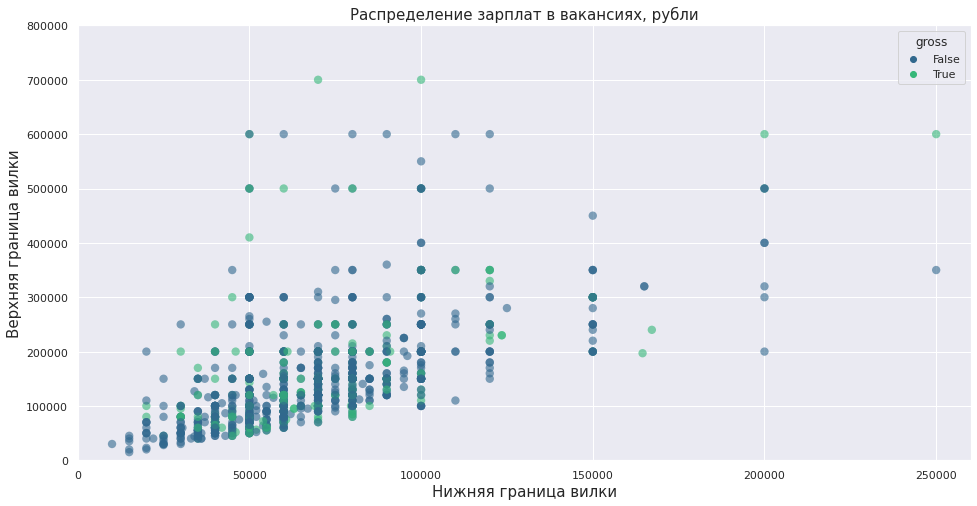

In [242]:
plt.figure(figsize=(16, 8))
sns.set(style='darkgrid')
rub_salary = salary_info[salary_info['salary.currency'] == 'RUR']
fig = sns.scatterplot(
    data=rub_salary,
    x='salary.from',
    y='salary.to',
    s=70,
    linewidth=0,
    hue='salary.gross',
    palette='viridis',
    alpha=0.6,
)

plt.xlim((0, 260000))
plt.ylim((0, 800000))
plt.ticklabel_format(style='plain')
plt.xlabel('Нижняя граница вилки', fontsize=15)
plt.ylabel('Верхняя граница вилки', fontsize=15)
plt.title('Распределение зарплат в вакансиях, рубли', fontsize=15)
plt.legend(title='gross')

Таким образом, в отличие от зарплаты аналитика, зарплаты менеджеров указывают с бОльшей шириной вилки.

Text(0.5, 1.0, 'Распределение размера зарплаты, рубли')

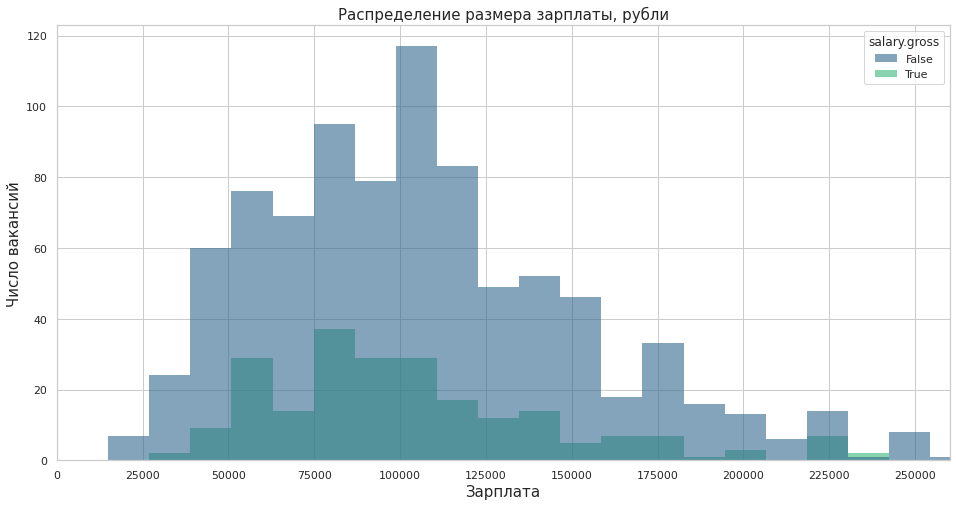

In [243]:
plt.figure(figsize=(16, 8))
sns.set(style='whitegrid')

fig = sns.histplot(
    data=rub_salary,
    x=0.5 * (rub_salary['salary.from'] + rub_salary['salary.to']),
    hue='salary.gross',
    linewidth=0,

    palette='viridis',
    alpha=0.6,
)

xmin = 0
xmax = 260000
plt.xlim((xmin, xmax))
fig.set_xticks(np.arange(xmin, xmax, 25000))
plt.xlabel('Зарплата', fontsize=15)
plt.ylabel('Число вакансий', fontsize=15)
plt.title('Распределение размера зарплаты, рубли', fontsize=15)

Интересно, что распределение зарплат в данном случае хорошо описывается нормальным распределением со смещённым центром. Возможно, это связано с тем, что мы имеем бОльшую выборку.

Вычислим медианные границы:

In [244]:
rub_salary[rub_salary['salary.gross'] == False].median()

salary.from      70000.0
salary.to       137000.0
salary.gross         0.0
dtype: float64

In [245]:
rub_salary[rub_salary['salary.gross'] == True].median()

salary.from      60700.0
salary.to       125000.0
salary.gross         1.0
dtype: float64

In [246]:
np.median(0.5 * (rub_salary['salary.from'] + rub_salary['salary.to']))

100000.0

Заметим, что медианная зп менеджера отличается всего лишь на 10 тысяч рублей от медианной зарплаты аналитика.

Повторим те же действия для зарплат в долларах:

In [ ]:
usd_eur_salary = salary_info.loc[salary_info['salary.currency'] != 'RUR']
# взято по официальному курсу
usd_div_eur = 0.91441
usd_eur_salary.loc[usd_eur_salary['salary.currency'] == 'EUR', ['salary.to', 'salary.from']] *= usd_div_eur
usd_eur_salary.loc[usd_eur_salary['salary.currency'] == 'EUR', 'salary.currency'] = 'USD'

In [248]:
not_null_gross = usd_eur_salary['salary.gross'].count()
cnt_gross = usd_eur_salary['salary.gross'].sum()
print(cnt_gross, not_null_gross - cnt_gross)

0 8


Поскольку указано всего лишь 8 зарплат, построим только scatterplot. Выборка слишком мала, чтобы делать по ней какие-то выводы.

In [251]:
usd_eur_salary[usd_eur_salary['salary.gross'] == False].median()

salary.from     1400.0
salary.to       3000.0
salary.gross       0.0
dtype: float64

In [253]:
np.median(0.5 * (usd_eur_salary['salary.from'] + usd_eur_salary['salary.to']))

1975.0

По тем данным, что у нас есть, зарплата в долларах для менеджера не даёт такого большого денежного преимущества, как оплата в долларах для аналитика.

**Вывод:**
1. Заметим, что менеджеры более востребованы на рынке, чем аналитики, что естественно вытекает из их ролей в бизнес-процесах.
2. Зарплаты менеджеров указываются преимущественно в рублях, в отличие от зарплат аналитиков, где можно было собрать не такую маленькую выборку.
3. Медианная ЗП аналитика всего лишь на 10 тысяч превышает медианную оплату менеджера.
4. На вакансию менеджеров ждут тех, кто умеет общаться с заказчиками и коллегами, работать в компанде и владеть навыками продажи.


---
### <font color="orange"><i>Сложная часть</i></font>

### Задача 2.   

Для *одной* из рассмотренных ранее профессий ответьте на следующие вопросы:  
- Какой опыт требуется для данной вакансии?
- Какие работодатели в топе? 
- В каком районе Москвы данная вакансия пользуется наибольшим и наименьшим спросом?

Не забудьте про визуализацию, для этого используйте библиотеку plotly. В частности, постройте распределений вакансий на карте.

Для построения последних двух графиков вам могут понадобиться <a target="_blank" href="https://ru.wikipedia.org/wiki/Список_станций_Московского_метрополитена">внешние данные</a>.

**В качестве анализа выберем Data Science**


1. Проанализируем требуемый опыт.

In [ ]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
fig = sns.countplot(x=ds_exp, color='crimson', alpha=0.8)
plt.legend()
fig.set_xticklabels(('От 1 до 3 лет', 'От 3 до 6 лет', 'Без опыта', 'Более 6 лет'))
plt.xlabel('Число резюме', fontsize=15)
plt.ylabel('Опыт работы', fontsize=15)
plt.title('Требуемый опыт работы для Data Science', fontsize=15)

Таким образом, на рынке более востребованы Middle+, Middle и Junior специалисты.

2. Проанализируем топ работодателей

In [ ]:
company = {}
for name in ds_employer_name:
    if name in company:
        company[name] += 1
    else:
        company[name] = 1
sorted_top_empl = pd.DataFrame(sorted(company.items(), key=lambda item: item[1], reverse=True),
                               columns=['Работодатель', 'Число вакансий'])
# переименую, чтобы занимали меньше места
sorted_top_empl['Работодатель'][4] = 'Центробанк'
sorted_top_empl['Работодатель'][7] = 'Минцифры'

Text(0.5, 1.0, 'Топ-15 нанимателей по числу вакансий')

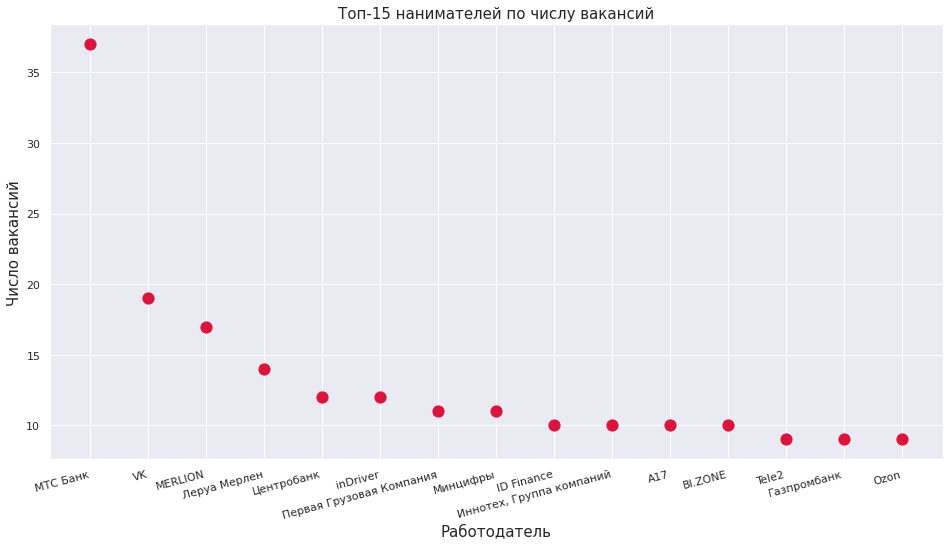

In [109]:
plt.figure(figsize=(16, 8))
sns.set(style='darkgrid')
plt.scatter(data=sorted_top_empl[0:15],
            x='Работодатель',
            y='Число вакансий',
            marker='.',
            s=500,
            color='crimson')
plt.xlabel('Работодатель', fontsize=15)
plt.ylabel('Число вакансий', fontsize=15)
plt.xticks(rotation=15, ha='right')
plt.title('Топ-15 нанимателей по числу вакансий', fontsize=15)

Таким образом, чаще всего аналитиков ищут IT-компании и банки.

3. Изобразим на карте распределение вакансий в двух масштабах.

In [ ]:
import plotly.express as px
fig = px.scatter_mapbox(lat=ds_pages_df['address.lat'],
                        lon=ds_pages_df['address.lng'],
                        color_discrete_sequence=["purple"],
                        zoom=11,
                        width=1000 ,
                        height=700,
                        center = dict(
                            lat = 55.753995,
                            lon = 37.614069,
                        ),
                        mapbox_style="open-street-map")
fig.show()

In [13]:
new_fig = px.scatter_mapbox(lat=ds_pages_df['address.lat'],
                            lon=ds_pages_df['address.lng'],
                            color_discrete_sequence=["purple"],
                            zoom=9,
                            width=1000 ,
                            height=700,
                            center = dict(
                                lat = 55.753995,
                                lon = 37.614069,
                            ),
                            mapbox_style="open-street-map")
new_fig.show()

Поскольку графики никак не экспортировались, с помощью `plotly.offline` я создала их копии и импортировала в документ с помощью `Image`, чтобы они оставались вне зависимости от директории размещения файла:

Далее объединим по районам, используя названия станций метро:

In [27]:
target_col = ['address.metro.station_id', 'address.metro.lat', 'address.metro.lng', 'address.metro.station_name']
stages = ds_pages_df.groupby(target_col).count().reset_index()

px.scatter_mapbox(
    lat=stages['address.metro.lat'],
    lon=stages['address.metro.lng'],
    zoom=10,
    color_discrete_sequence=["purple"],
    width=1000 ,
    height=700,
    center = dict(
        lat = 55.753995,
        lon = 37.614069,
    ),
    mapbox_style="open-street-map",
    size=stages['id'],
    hover_name=stages['address.metro.station_name']
)

Какие выводы можно сделать из построенных графиков?

**Вывод:**
Таким образом, офисы нанимателей располагаются ближе к центру Москвы. Внутри третьего транспортного кольца располагается подавляющее большинство вакансий, вне него не такое большое количество, что можно заметить по второму графику. Особая концентрация вакансия находится в районе Делового Центра в Москва-Сити, что связано с большим расположением офисов различных компаний и в Замоскорецком районе, где рядом с Павелецким вокзалом располагается крупный бизнес-центр.

Популярными для размещения офисов нанимателей стали станции метро Бауманская, Белорусская, Павелецкая, Технопарк, Аэропорт, Динамо.